In [1]:
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import sqlite3 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from rasterio.mask import mask
import rasterio
from sklearn.model_selection import cross_val_score
import numpy as np
import rasterio
from matplotlib.colors import ListedColormap

In [2]:
#Q1 How many counties are in Wisconsin?
wisconsin = gpd.read_file('counties.geojson')
len(wisconsin['NAME'])

72

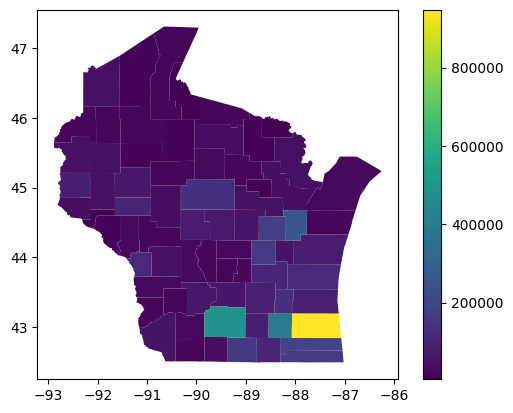

In [3]:
#Q2 What is the population of each county in WI?
wisconsin.plot(column = 'POP100', legend = True)
plt.show()

In [4]:
#adding AREALAND
conn = sqlite3.connect('counties_tracts.db')
counties = pd.read_sql("""SELECT * FROM counties""", conn)
AREALAND = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
wisco_areland = wisconsin.merge(wisconsin, how='left', left_on='NAME', right_on='NAME')
conn.close()

wisconsin['AREALAND'] = AREALAND

train, test = train_test_split(wisconsin, random_state=320,test_size=0.25)

In [5]:
#Q3 What are the counties in the test dataset?
counties_test = []
for i in test["NAME"]:
    counties_test.append(i)
    
counties_test

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [6]:
#Q4 How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?
model = LinearRegression() 

model.fit(train[['AREALAND']], train['POP100'])
model.score(test[['AREALAND']], test['POP100'])

0.022002661530554857

In [7]:
#Q5 What is the predicted population of a county with 300 square miles of area, according to the model?
# model.predict(train[['AREALAND']])
number = 300*2.59*(1000**2)
input_data = pd.DataFrame({'AREALAND': [number]})
input_data
# predicted_population = model.predict(test['AREALAND'].iloc[0])
model.predict(input_data)[0]

89016.40396725974

In [8]:
#Adding HU100
conn = sqlite3.connect('counties_tracts.db')
query = """
SELECT counties.NAME, SUM(HU100) as HU100 FROM tracts
INNER JOIN counties ON counties.COUNTY == tracts.COUNTY
GROUP BY tracts.COUNTY
"""
hu100 = pd.read_sql(query, conn)
conn.close()
merged_gdf = wisconsin.merge(hu100, left_on = "NAME", right_on = "NAME")
train1, test1 = train_test_split(merged_gdf, random_state=320,test_size=0.25)

In [9]:
#Q6 What are the counties in the test dataset?
list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [10]:
#Q7 What are the HU100 values for the counties in the test dataset?
test1.set_index(test['NAME'])['HU100'].to_dict()

{'Kewaunee County': 9304,
 'Calumet County': 19695,
 'Adams County': 17436,
 'Eau Claire County': 42151,
 'Milwaukee County': 418053,
 'Ashland County': 9656,
 'Wood County': 34088,
 'Dodge County': 37005,
 'Sauk County': 29708,
 'Clark County': 15076,
 'Pepin County': 3579,
 'Taylor County': 10582,
 'Iron County': 5999,
 'Outagamie County': 73149,
 'Florence County': 4780,
 'Oneida County': 30125,
 'Pierce County': 16132,
 'Grant County': 21581}

In [11]:
#Q8 How much variance in the POP100 can a LinearRegression model explain based only on HU100?
hu100_train1 = train1[['HU100']] 
pop100_train1 = train1['POP100']  

cv = cross_val_score(model, hu100_train1, pop100_train1, cv = 5, scoring = 'r2')
cv.mean()

0.9652534544116037

In [12]:
#Q9 What is the standard deviation of the cross validation scores from Q8?
mean = cv.mean()

std_dev = np.sqrt(((cv - mean) ** 2).sum() / len(cv))
std_dev

0.03704265206670459

In [13]:
#Q10 What is the formula relating POP100 and HU100?
hu100_train1 = train1[['HU100']] 
pop100_train1 = train1['POP100'] 

fit = model.fit(hu100_train1, pop100_train1)

coefficient = round(fit.coef_[0], 2)
intercept = round(fit.intercept_, 2)

pop100 = f"POP100 = {coefficient}*HU100 + {intercept}"
pop100

'POP100 = 2.39*HU100 + -7910.46'

In [14]:
#Q11 What is the r-squared score of your fitted model (from Q10)?
hu100_test1 = test1[['HU100']] 
pop100_test1 = test1['POP100']

prediction_hu = model.predict(hu100_test1)
r2 = r2_score(pop100_test1, prediction_hu)
r2

0.9958323488562859

<function matplotlib.pyplot.show(close=None, block=None)>

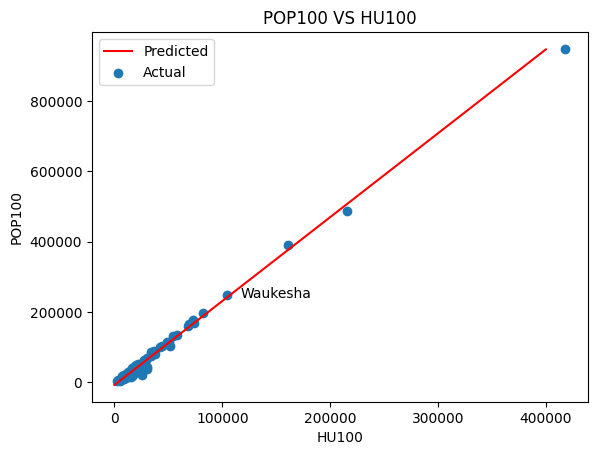

In [15]:
#Q12 What is the relationship between HU100 and POP100, visually?
# hu100_train1 = train1['HU100'] 
# pop100_train1 = train1['POP100'] 

hu100_test1 = merged_gdf['HU100'] 
pop100_test1 = merged_gdf['POP100'] 
coef = model.coef_
yint = model.intercept_

waukesha = merged_gdf[merged_gdf['NAME'] == 'Waukesha County']

sample = list(range(0, 400000, 10))

y = lambda x: coef*x + yint

plt.plot(sample, y(sample), color = 'red', label = "Predicted")
plt.scatter(hu100_test1, pop100_test1, label = 'Actual')
plt.title('POP100 VS HU100')
plt.xlabel('HU100')
plt.ylabel('POP100')
plt.text(x=waukesha['POP100'].iloc[0]*.3, y=waukesha['HU100'].iloc[0]*1.5, s="Waukesha")
plt.legend()
plt.show

In [16]:
#Q13 How many numbers in matrix A are between 1 and 4 (inclusive)?
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

count = np.sum((A >= 1) & (A <= 4))
count

13

In [17]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)


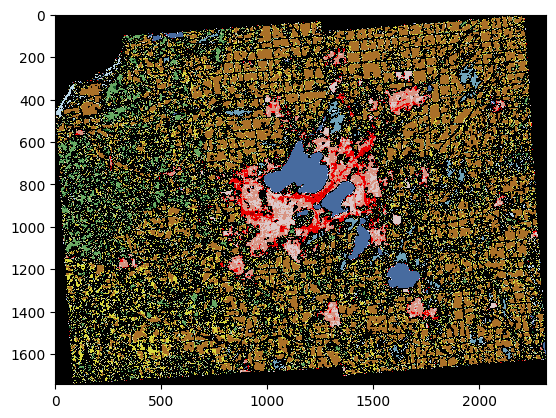

In [18]:
#Q14 How does Dane County look?
# rasterio.open("land.zip")
from rasterio.mask import mask
data = rasterio.open("zip://./land.zip") 
dane = merged_gdf[merged_gdf['NAME'] == 'Dane County']
matrix, _ = mask(data, dane.to_crs(data.crs)["geometry"], crop=True)
matrix = matrix[0]
plt.imshow(matrix, cmap = custom_cmap, vmin = 0, vmax = 255)

In [19]:
#Q15 What portion of Dane County is "Crops"?
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

crops = land_use["crops"]
            
non_zero = np.count_nonzero(matrix)
crops_portion = np.sum(matrix == crops)
crops_portion/non_zero

0.46705544316564085

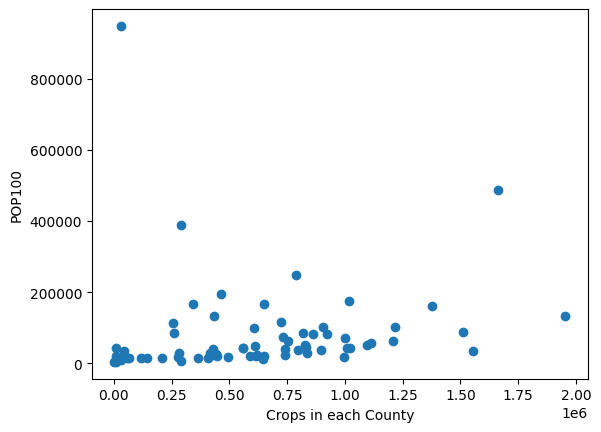

In [20]:
#Q16 What is the Relationship Between POP100 and crops?
x = []
y = []
data = rasterio.open("zip://./land.zip") 
counties = merged_gdf['NAME']
for county in counties:
    county_names = merged_gdf[merged_gdf['NAME'] == county]
    matrix, _ = mask(data, county_names.to_crs(data.crs)["geometry"], crop=True)
    matrix = matrix[0]
    # plt.imshow(matrix, cmap = custom_cmap, vmin = 0, vmax = 255)
    crops = land_use["crops"]
    crops_portion = np.sum(matrix == crops)
    x.append(crops_portion)
    y.append(county_names['POP100'].values[0])
    
plt.scatter(x, y)
plt.xlabel("Crops in each County")
plt.ylabel("POP100")
plt.show()

In [21]:
#Feature Analysis
tracts = gpd.read_file('tracts.shp')
data = rasterio.open("zip://./land.zip")
 
geoids = tracts['GEOID']
for i, county in enumerate(geoids):
    geoids_names = tracts[tracts['GEOID'] == county]
    matrix, _ = mask(data, geoids_names.to_crs(data.crs)["geometry"], crop=True)
    matrix = matrix[0]

    for lands in land_use:
        land_num = land_use[lands]
        tracts.loc[i, lands] = (matrix == land_num).sum()


train2, test2 = train_test_split(tracts, random_state=320,test_size=0.25)

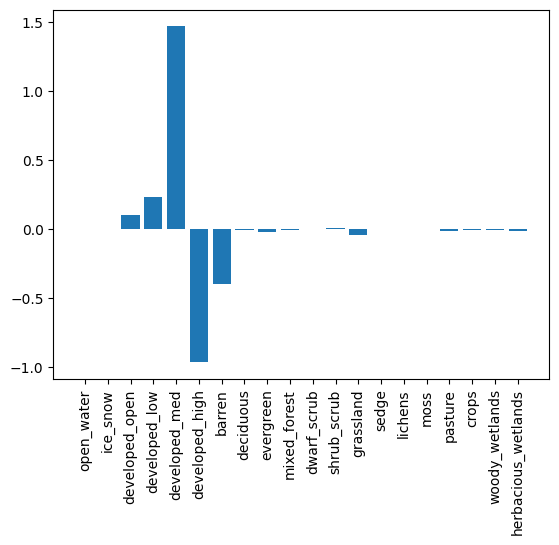

The graph shows what land types are in our land.zip file, along with the population. looking at the graph, I can see that there is alot of correlation between people and developed_med land. I can use this information in order to estimate where expected number of people couldlive in for that type of land.


In [22]:
#Q17 What features does your model rely on most?
features = []
for i in land_use:
    features.append(i)

model = LinearRegression()
model.fit(train2[features], train2["POP100"])
sample = model.coef_

plt.bar(features, sample)
plt.xticks(rotation=90)
plt.show()
# Write a comment discussing what the graph is showing you and how you might use that information in building your own model
print("The graph shows what land types are in our land.zip file, along with the population. looking at the graph, I can see that there is alot of "
      "correlation between people and developed_med land. I can use this information in order to estimate where expected number of people could"
      "live in for that type of land.")

In [23]:
# Model Creation and Analysis
model = LinearRegression()

# model1.fit(train2[["developed_low"]], train2["POP100"])
# model2.fit(train2[["developed_med"]], train2["POP100"])

cross_validation1 = cross_val_score(model, train2[["developed_low"]], train2["POP100"])
cross_validation2 = cross_val_score(model, train2[["developed_med"]], train2["POP100"])

In [24]:
#Q18 What is the mean and variance of the cross validation scores from both of your models?
def std(array):
    mean = np.mean(array) 
    squared_diff = (array - mean) ** 2  
    variance = np.mean(squared_diff) 
    std_dev = np.sqrt(variance)  
    return std_dev

cross_validation1_mean = cross_validation1.mean()
cross_validation2_mean = cross_validation2.mean()
cross_validation1_std = std(cross_validation1)
cross_validation2_std = std(cross_validation2)

models = {
'model1-avg': cross_validation1_mean,
 'model1-std': cross_validation1_std,
 'model2-avg': cross_validation2_mean,
 'model2-std': cross_validation2_std
}
# (a) mean of cross validation scores is high, (b) variance of cross validation scores is low. 
# Additional factors you might consider are (c) model is simple, and (d) anything else you think is important.
print("A) I would choose model2, because the mean of it is greater than model1")
print('B) I would choose model2, because the std dev is lower, which means the data is more consistent')
print('C) both models are very similar, as they both use the same code to achieve results.')
print('D) Model 2 is the better choice, because it has a higher mean and a lower std_dev. This will lead to better results in the end.')
models

A) I would choose model2, because the mean of it is greater than model1
B) I would choose model2, because the std dev is lower, which means the data is more consistent
C) both models are very similar, as they both use the same code to achieve results.
D) Model 2 is the better choice, because it has a higher mean and a lower std_dev. This will lead to better results in the end.


{'model1-avg': 0.1396296094533691,
 'model1-std': 0.03298066231229739,
 'model2-avg': 0.3827922254716966,
 'model2-std': 0.04072716649104287}

In [25]:
#Q19 How does your recommended model score against the test dataset?
model.fit(train2[["developed_med"]], train2["POP100"])
model.score(test2[["developed_med"]], test2["POP100"])

0.35185042724015203